In [1]:
import numpy as np
from typing import Tuple, List
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles

In [2]:
class KMeans:
    def __init__(self, n_clusters: int, max_iters: int = 100, random_state: int = None):
        """
        Initialize K-means clustering algorithm.
        
        Args:
            n_clusters: Number of clusters (K)
            max_iters: Maximum number of iterations for convergence
            random_state: Random seed for reproducibility
        """
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None
        
    def fit(self, X: np.ndarray) -> 'KMeans':
        """
        Fit K-means clustering to the data.
        
        Args:
            X: Input data of shape (n_samples, n_features)
            
        Returns:
            self: Fitted model instance
        """
        if self.random_state:
            np.random.seed(self.random_state)
            
        n_samples, n_features = X.shape
        idx = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[idx]
        
        for _ in range(self.max_iters):
            old_centroids = self.centroids.copy()
            
            self.labels = self._assign_clusters(X)
            
            self._update_centroids(X)
            
            if self._has_converged(old_centroids):
                break
                
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict cluster labels for new data.
        
        Args:
            X: Input data of shape (n_samples, n_features)
            
        Returns:
            labels: Predicted cluster labels
        """
        return self._assign_clusters(X)
    
    def _assign_clusters(self, X: np.ndarray) -> np.ndarray:
        """
        Assign each point to the nearest centroid.
        
        Args:
            X: Input data of shape (n_samples, n_features)
            
        Returns:
            labels: Cluster assignments for each point
        """
        distances = np.zeros((X.shape[0], self.n_clusters))
        
        for k in range(self.n_clusters):
            diff = X - self.centroids[k]
            distances[:, k] = np.sqrt(np.sum(diff ** 2, axis=1))
            
        return np.argmin(distances, axis=1)
    
    def _update_centroids(self, X: np.ndarray) -> None:
        """
        Update centroid positions based on mean of assigned points.
        
        Args:
            X: Input data of shape (n_samples, n_features)
        """
        for k in range(self.n_clusters):
            cluster_points = X[self.labels == k]
            if len(cluster_points) > 0:
                self.centroids[k] = np.mean(cluster_points, axis=0)
    
    def _has_converged(self, old_centroids: np.ndarray, tol: float = 1e-4) -> bool:
        """
        Check if the algorithm has converged.
        
        Args:
            old_centroids: Centroids from previous iteration
            tol: Tolerance for convergence
            
        Returns:
            bool: True if converged, False otherwise
        """
        return np.all(np.abs(old_centroids - self.centroids) < tol)
    
    def inertia(self, X: np.ndarray) -> float:
        """
        Calculate the sum of squared distances to nearest centroids.
        
        Args:
            X: Input data of shape (n_samples, n_features)
            
        Returns:
            float: Inertia score
        """
        distances = np.zeros(X.shape[0])
        labels = self._assign_clusters(X)
        
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                diff = cluster_points - self.centroids[k]
                distances[labels == k] = np.sum(diff ** 2, axis=1)
                
        return np.sum(distances)

In [3]:
def generate_synthetic_datasets() -> dict:
    """
    Generate various synthetic datasets for testing K-means clustering.
    Returns a dictionary containing different test cases.
    """
    np.random.seed(42)
    
    X_blobs, y_blobs = make_blobs(
        n_samples=300,
        centers=4,
        cluster_std=1.2,
        random_state=42
    )
    
    X_aniso = np.random.randn(300, 2)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X_aniso, transformation)
    X_aniso[100:200] += [2, 2]
    X_aniso[200:] += [-2, 2]
    
    X_moons, y_moons = make_moons(n_samples=300, noise=0.15, random_state=42)
    
    X_circles, y_circles = make_circles(n_samples=300, noise=0.15, factor=0.5, random_state=42)
    
    return {
        'blobs': (X_blobs, 4),
        'anisotropic': (X_aniso, 3),
        'moons': (X_moons, 2),
        'circles': (X_circles, 2)
    }

In [7]:
def plot_clustering_results(datasets: dict, kmeans_class) -> None:
    """
    Plot the clustering results for each dataset.
    
    Args:
        datasets: Dictionary containing the synthetic datasets
        kmeans_class: The KMeans class to use for clustering
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle('K-means Clustering Results on Different Datasets', fontsize=16)
    
    for (idx, (name, (X, n_clusters))), ax in zip(enumerate(datasets.items()), axes.ravel()):
        kmeans = kmeans_class(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X)
        labels = kmeans.labels  
        
        scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.7)
        centers = kmeans.centroids
        ax.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, linewidth=3, 
                  label='Centroids')
        
        inertia = kmeans.inertia(X)
        
        ax.set_title(f'{name.capitalize()}\nInertia: {inertia:.1f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [9]:
def plot_elbow_method(X: np.ndarray, k_range: range, kmeans_class) -> None:
    """
    Plot the elbow curve to help determine optimal number of clusters.
    
    Args:
        X: Input data
        k_range: Range of k values to try
        kmeans_class: The KMeans class to use
    """
    inertias = []
    
    for k in k_range:
        kmeans = kmeans_class(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia(X))
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True, alpha=0.3)
    plt.show()

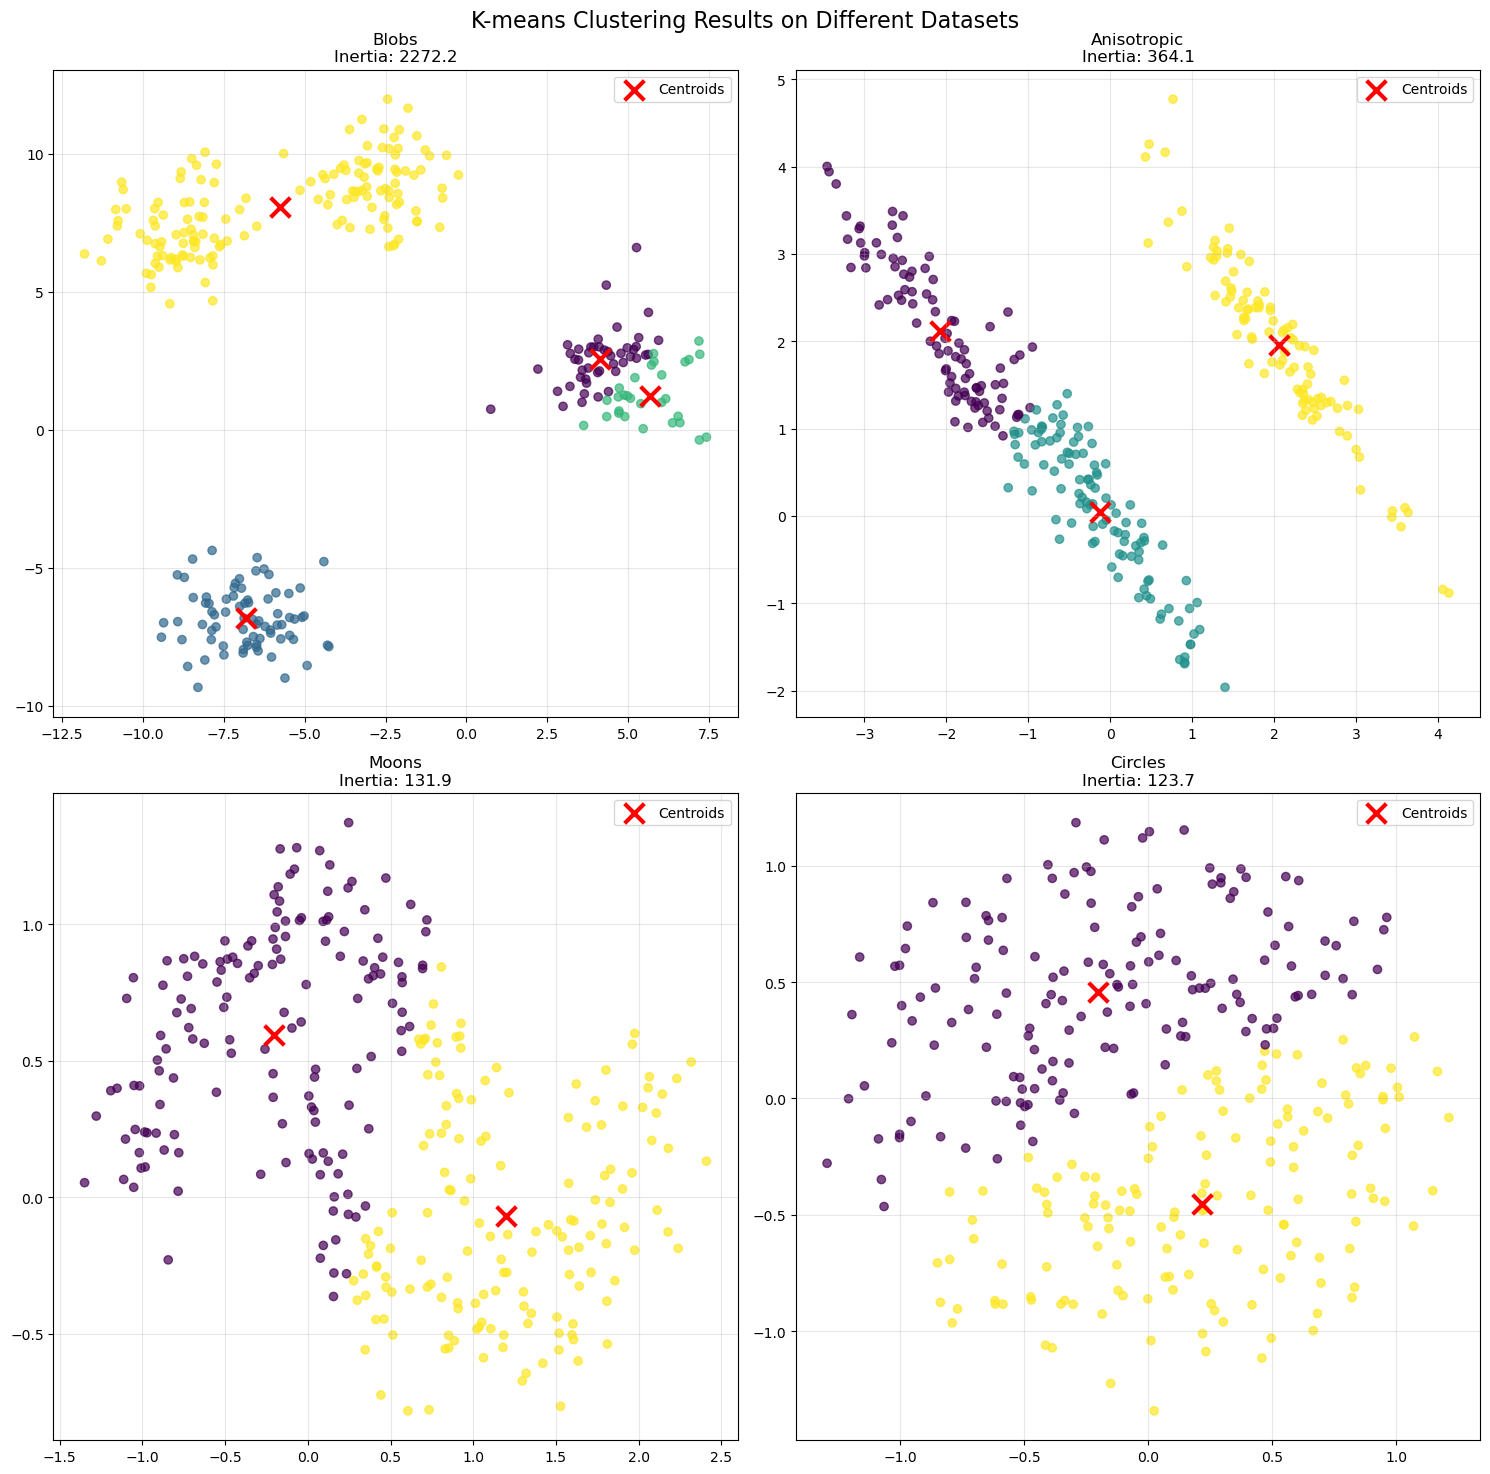

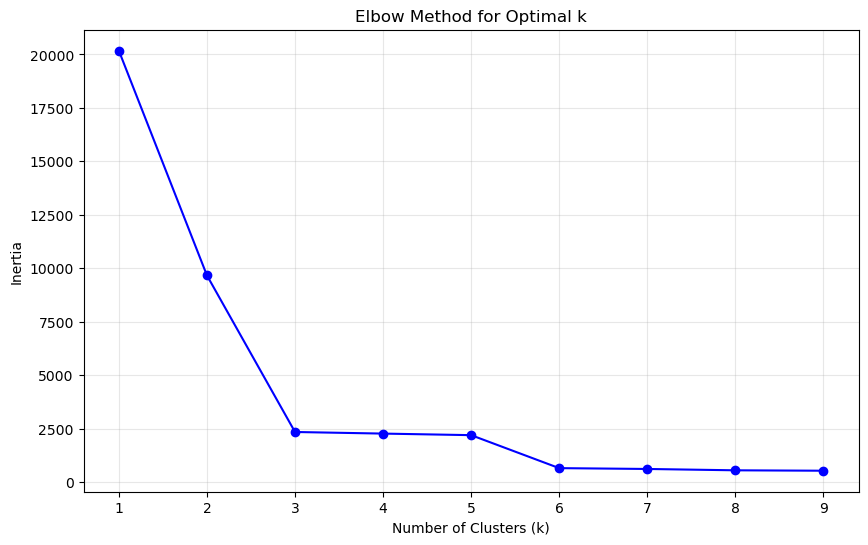

In [11]:
if __name__ == "__main__":
    datasets = generate_synthetic_datasets()
    
    plot_clustering_results(datasets, KMeans)
    
    X_blobs = datasets['blobs'][0]
    plot_elbow_method(X_blobs, range(1, 10), KMeans)